In [1]:
import gammapy
print(gammapy.__version__)

0.13


# **v0.13 (Adaptive)RingBackroundEstimator**

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
from scipy.stats import norm
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import MapMaker, MapDataset, PSFKernel, MapMakerRing
from gammapy.cube.models import SkyModel, BackgroundModel
from gammapy.spectrum.models import PowerLaw
from gammapy.spectrum import create_crab_spectral_model
from gammapy.image.models import SkyPointSource
from gammapy.detect import compute_lima_on_off_image
from gammapy.scripts import SpectrumAnalysisIACT
from gammapy.utils.fitting import Fit
from gammapy.background import RingBackgroundEstimator, AdaptiveRingBackgroundEstimator

In [3]:
data_store = DataStore.from_file(
    "/home/luca/GAMMAPY_DATA/hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_table = data_store.obs_table[mask]
observations = data_store.get_observations(obs_table["OBS_ID"])

energy_axis = MapAxis.from_edges(
    np.logspace(0, 1.0, 5), unit="TeV", name="ENERGY", interp="log"
)
geom = WcsGeom.create(
    skydir=SkyCoord(83.633, 22.014, unit="deg"),
    binsz=0.02,
    width=(10, 10),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

# Ring (non adaptive)

In [28]:
%%timeit
maker = MapMaker(geom, offset_max="2 deg")
maps = maker.run(observations)
images = maker.run_images()

regions = CircleSkyRegion(center=SkyCoord(83.633, 22.014, unit="deg"), radius=0.15 * u.deg)
mask = Map.from_geom(geom)
mask.data = mask.geom.region_mask([regions], inside=False)

ring_bkg = RingBackgroundEstimator(r_in="0.2 deg", width="0.3 deg")

im = MapMakerRing(
    geom=geom,
    offset_max=2.0 * u.deg,
    exclusion_mask=mask,
    background_estimator=ring_bkg,
)

images = im.run_images(observations)

5.46 s ± 469 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
images.keys()

dict_keys(['on', 'exposure_on', 'off', 'exposure_off', 'exposure'])

/home/luca/anaconda3/envs/gammapy-0.13/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 1800x288 with 8 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff349c7fd68>)

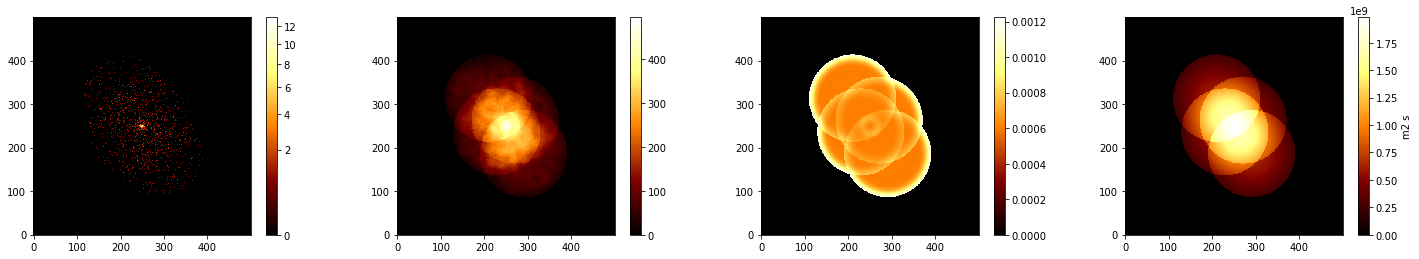

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))
images["on"].sum_over_axes().plot(add_cbar=True, stretch="sqrt", ax=axes[0])
images["off"].sum_over_axes().plot(add_cbar=True, ax=axes[1])
(images["exposure_on"]/images["exposure_off"]).sum_over_axes().plot(add_cbar=True, ax=axes[2])
images["exposure"].sum_over_axes().plot(add_cbar=True, ax=axes[3])

In [22]:
(images["exposure_on"]/images["exposure_off"]).sum_over_axes().data[200][200]

0.00077920605

# Adaptive Ring

In [29]:
%%timeit
maker = MapMaker(geom, offset_max="2 deg")
maps = maker.run(observations)
images = maker.run_images()

regions = CircleSkyRegion(center=SkyCoord(83.633, 22.014, unit="deg"), radius=0.15 * u.deg)
mask = Map.from_geom(geom)
mask.data = mask.geom.region_mask([regions], inside=False)

ring_bkg = AdaptiveRingBackgroundEstimator(r_in="0.2 deg", r_out_max="2 deg", width="0.3 deg", stepsize="0.2 deg")

im = MapMakerRing(
    geom=geom,
    offset_max=2.0 * u.deg,
    exclusion_mask=mask,
    background_estimator=ring_bkg,
)

images = im.run_images(observations)

7.52 s ± 622 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
images.keys()

dict_keys(['on', 'exposure_on', 'off', 'exposure_off', 'exposure'])

/home/luca/anaconda3/envs/gammapy-0.13/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 1800x288 with 8 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff370fddb00>)

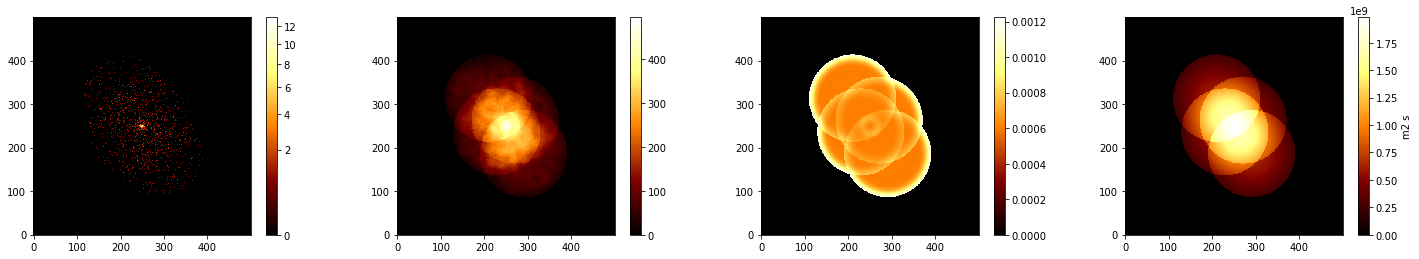

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))
images["on"].sum_over_axes().plot(add_cbar=True, stretch="sqrt", ax=axes[0])
images["off"].sum_over_axes().plot(add_cbar=True, ax=axes[1])
(images["exposure_on"]/images["exposure_off"]).sum_over_axes().plot(add_cbar=True, ax=axes[2])
images["exposure"].sum_over_axes().plot(add_cbar=True, ax=axes[3])

In [27]:
(images["exposure_on"]/images["exposure_off"]).sum_over_axes().data[200][200]

0.00077920605